Week 6 Toturial

This notebook serves as support material to implement a Hybrid Non-dominated Sorting Genetic Algorithm (NSGA-II)

Basic Concept:
Multiobjective Optimization Problem (MOP)
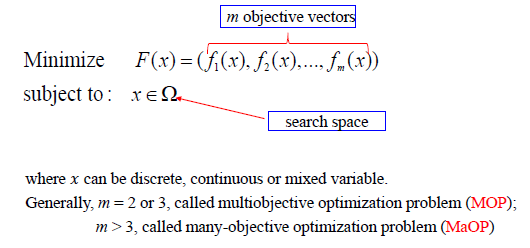

Simple Example: two confliced objectives
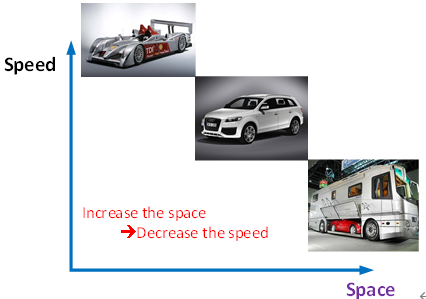

Domination Relationship: y dominates x if,y is no worse than x in any obj, and 
y is better than x in at least one objective
For examples in the folloing figure:
A dominates C,
Besides, B and A are not comparable
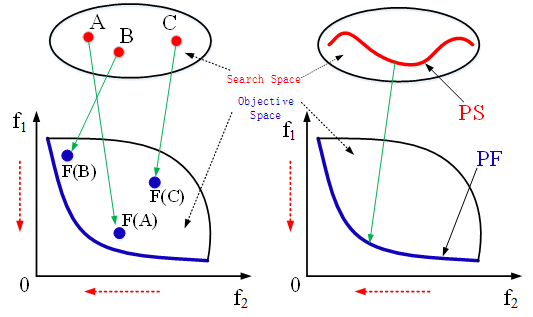
x is Pareto optimal if no other solution dominates it

Pareto set (PS) = the set of all Pareto optimal solutions in the variable/variable/decision space.

Pareto front (PF) = the image of the PS in the objective space.

NSGA-II: Non-dominated Sorting Genetic Algorithm
This algorithm is most famous genetic or evolutionary algorthim used to solving multiobjective optimization problem. The algorithm follows the general outline of a genetic algorithm with a modified mating and survival selection. In NSGA-II, first, individuals are selected frontwise. By doing so, there will be the situation where a front needs to be split because not all individuals are allowed to survive. In this splitting front, solutions are selected based on crowding distance.
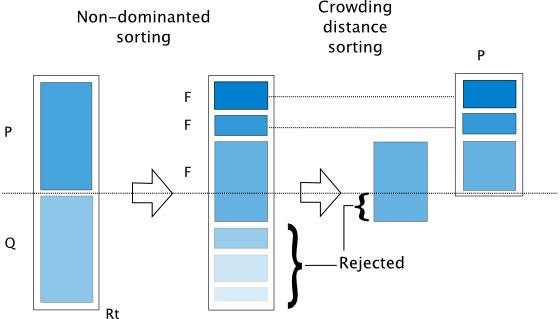
The crowding distance is the Manhatten Distance in the objective space. However, the extreme points are desired to be kept every generation and, therefore, get assigned a crowding distance of infinity.
Furthermore, to increase some selection pressure, NSGA-II uses a binary tournament mating selection. Each individual is first compared by rank and then crowding distance. There is also a variant in the original C code where instead of using the rank, the domination criterium between two solutions is used.

The general framework of an evolutionary algorithm:
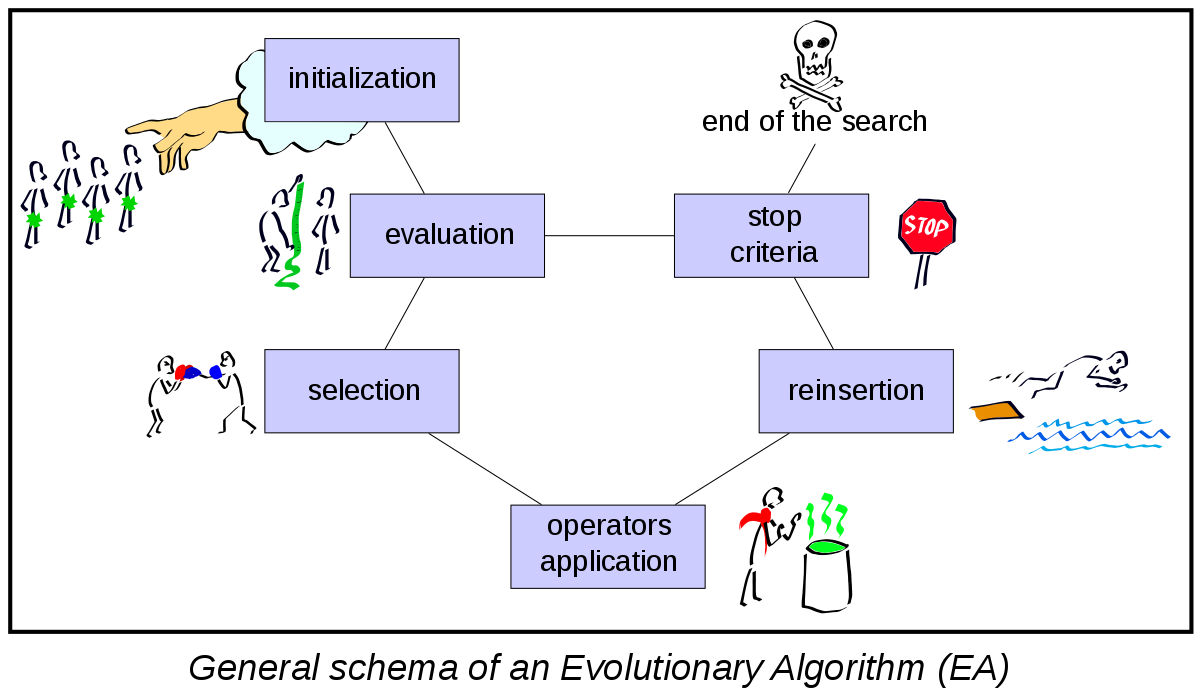

The pseudocode of NSGA-II:
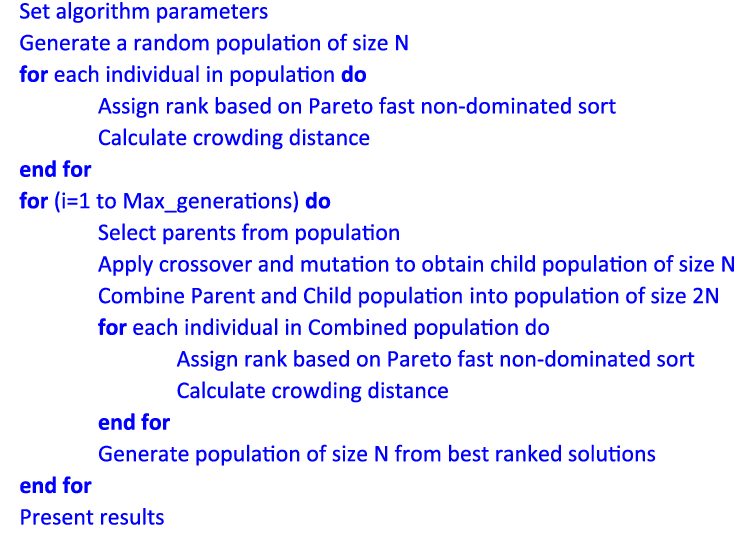

Next we will implement NSGA-II using Python

In [6]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
#_initialize a Population by randomly sampling n solutions in the search space____________________________________________________________________________
def random_population(nv,n,lb,ub):
    # nv = numver of variables
    # n = number of random solutions
    # lb = lower bound
    # ub = upper bound
    pop=np.zeros((n, nv)) 
    for i in range(n):
        pop[i,:] = np.random.uniform(lb,ub)
    return pop

In [8]:
#_Reproducing the offspring population by the crossover operator____________________________________________________________________________
def crossover(pop, crossover_rate):
    offspring = np.zeros((crossover_rate, pop.shape[1]))
    for i in range(int(crossover_rate/2)):
        r1=np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        cutting_point = np.random.randint(1, pop.shape[1])
        offspring[2*i, 0:cutting_point] = pop[r1, 0:cutting_point]
        offspring[2*i, cutting_point:] = pop[r2, cutting_point:]
        offspring[2*i+1, 0:cutting_point] = pop[r2, 0:cutting_point]
        offspring[2*i+1, cutting_point:] = pop[r1, cutting_point:]
 
    return offspring

In [9]:
#__Mutate the solutions of the offspring population___________________________________________________________________________
def mutation(pop, mutation_rate):
    offspring = np.zeros((mutation_rate, pop.shape[1]))
    for i in range(int(mutation_rate/2)):
        r1=np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        cutting_point = np.random.randint(0, pop.shape[1])
        offspring[2*i] = pop[r1]
        offspring[2*i,cutting_point] = pop[r2,cutting_point]
        offspring[2*i+1] = pop[r2]
        offspring[2*i+1, cutting_point] = pop[r1, cutting_point]
 
    return offspring

In [10]:
#_reproduce the offspring by local_search operator____________________________________________________________________________
def local_search(pop, n, step_size):
    # number of offspring chromosomes generated from the local search
    offspring = np.zeros((n, pop.shape[1]))
    for i in range(n):
        r1=np.random.randint(0,pop.shape[0])
        chromosome = pop[r1,:]
        r2=np.random.randint(0,pop.shape[1])
        chromosome[r2] += np.random.uniform(-step_size,step_size)
        if chromosome[r2] < lb[r2]:
            chromosome[r2]  = lb[r2]
        if chromosome[r2] > ub[r2]:
            chromosome[r2]  = ub[r2]       
       
        offspring[i,:] = chromosome
    return offspring

In [11]:
#_evaluate the fitness of the solutions (the objective values in the objective space)____________________________________________________________________________
def evaluation(pop):
    fitness_values = np.zeros((pop.shape[0], 2)) # because of 2 objective functions
    for i, x in enumerate(pop):
      
        obj1 = 0
        for j in range(2):
            obj1 += - 10*math.exp(-0.2*math.sqrt((x[j])**2 + (x[j+1])**2))
 
        obj2 = 0
        for j in range(3):
            obj2 += (abs(x[j]))**0.8 + 5*math.sin((x[j])**3)
 
        fitness_values[i,0] = obj1 # objective 1
        fitness_values[i,1] = obj2 # objective 2
 
    return fitness_values

In [12]:
#_define the crowding distance based on solutions fitness in the objective space____________________________________________________________________________
def crowding_calculation(fitness_values):
     
    pop_size = len(fitness_values[:, 0])
    fitness_value_number = len(fitness_values[0, :])
    matrix_for_crowding = np.zeros((pop_size, fitness_value_number))
    normalize_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0) # normalize the fitness values
    for i in range(fitness_value_number):
        crowding_results = np.zeros(pop_size)
        crowding_results[0] = 1 # extreme point has the max crowding distance
        crowding_results[pop_size - 1] = 1 # extreme point has the max crowding distance
        sorting_normalize_fitness_values = np.sort(normalize_fitness_values[:, i])
        sorting_normalized_values_index = np.argsort(normalize_fitness_values[:, i])
        # crowding distance calculation
        crowding_results[1:pop_size - 1] = (sorting_normalize_fitness_values[2:pop_size] - sorting_normalize_fitness_values[0:pop_size - 2])
        re_sorting = np.argsort(sorting_normalized_values_index) # re_sorting to the orginal order
        matrix_for_crowding[:, i] = crowding_results[re_sorting]
 
    crowding_distance = np.sum(matrix_for_crowding, axis=1) # crowding distance of each solution
 
    return crowding_distance

In [13]:
#_Environmental selection based on the crowding distance of solutions, aiming to maintain the diversity of the population____________________________________________________________________________
def remove_using_crowding(fitness_values, number_solutions_needed):
   
    pop_index = np.arange(fitness_values.shape[0])
    crowding_distance = crowding_calculation(fitness_values)
    selected_pop_index = np.zeros((number_solutions_needed))
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))
     
    for i in range(number_solutions_needed):
        pop_size = pop_index.shape[0]
        solution_1 = rn.randint(0, pop_size - 1)
        solution_2 = rn.randint(0, pop_size - 1)
        if crowding_distance[solution_1] >= crowding_distance[solution_2]:
            # solution 1 is better than solution 2
            selected_pop_index[i] = pop_index[solution_1]
            selected_fitness_values[i, :] = fitness_values[solution_1, :]
            pop_index = np.delete(pop_index, (solution_1), axis=0) # remove the selected solution
            fitness_values = np.delete(fitness_values, (solution_1), axis=0) # remove the fitness of the selected solution
            crowding_distance = np.delete(crowding_distance, (solution_1), axis=0) # remove the related crowding distance
        else:
            # solution 2 is better than solution 1
            selected_pop_index[i] = pop_index[solution_2]
            selected_fitness_values[i, :] = fitness_values[solution_2, :]
            pop_index = np.delete(pop_index, (solution_2), axis=0)
            fitness_values = np.delete(fitness_values, (solution_2), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)
 
    selected_pop_index = np.asarray(selected_pop_index, dtype=int) # Convert the data to integer 
     
    return (selected_pop_index)

In [14]:
#_Fast Nondominated-based Sorting, dividing the population into multiple front based on the fitness of solutions___________________________________________________________________________
def pareto_front_finding(fitness_values, pop_index):
 
    pop_size = fitness_values.shape[0]
    pareto_front = np.ones(pop_size, dtype=bool) # initially assume all solutions are in pareto front by using "1"
    for i in range(pop_size):
        for j in range(pop_size):
            if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                pareto_front[i] = 0 # i is not in pareto front because j dominates i
                break # no more comparision is needed to find out which one is dominated
     
    return pop_index[pareto_front]

In [15]:
#_Environmental selection based on the nondominated level of solutions, aiming to preserve the convergece of the population
#Convergence-first and Diversity-Second____________________________________________________________________________
def selection(pop, fitness_values, pop_size):
     
    pop_index_0 = np.arange(pop.shape[0])
    pop_index = np.arange(pop.shape[0])
    pareto_front_index = []
     
    while len(pareto_front_index) < pop_size:
        new_pareto_front = pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
        total_pareto_size = len(pareto_front_index) + len(new_pareto_front)
        # check the size of pareto front, if larger than pop_size, remove some solutions using crowding criterion
        if total_pareto_size > pop_size:
            number_solutions_needed = pop_size - len(pareto_front_index)
            selected_solutions = (remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed))
            new_pareto_front = new_pareto_front[selected_solutions]
  
        pareto_front_index = np.hstack((pareto_front_index, new_pareto_front)) # add to pareto
        remaining_index = set(pop_index) - set(pareto_front_index)
        pop_index_0 = np.array(list(remaining_index))
    
    selected_pop = pop[pareto_front_index.astype(int)]
 
    return selected_pop

In [16]:
#_initialization___________________________________________________________________________
# Parameters
nv = 3
lb = [-5, -5, -5]
ub = [5, 5, 5]
pop_size = 150
rate_crossover = 20
rate_mutation = 20
rate_local_search = 10
step_size = 0.1
pop = random_population(nv,pop_size,lb,ub)

In [17]:
#_Using The Hybride NSGA-II to solve the default problem____________________________________________________________________________
# Main loop of NSGA II 
for i in range(10):
    offspring_from_crossover = crossover(pop,rate_crossover)
    offspring_from_mutation = mutation(pop,rate_mutation)
    offspring_from_local_search = local_search(pop, rate_local_search, step_size)
    # extend the population
    pop = np.append(pop, offspring_from_crossover, axis=0)
    pop = np.append(pop, offspring_from_mutation, axis=0)
    pop = np.append(pop, offspring_from_local_search, axis=0)
    fitness_values = evaluation(pop)
    pop = selection(pop,fitness_values, pop_size)
    print('iteration:', i)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


_________________
Optimal solutions:
       x1               x2                 x3
[[-0.00370188 -0.32618323  0.01449453]
 [ 0.18392309  0.0235425   0.22143901]
 [-0.6799538   0.29308352  0.22143901]
 [-1.06977823  0.0369782  -0.90334617]
 [-0.00370188 -1.26163774 -1.0481187 ]
 [-0.72507769 -1.31996053 -1.154408  ]
 [ 1.68290084 -1.08236329 -0.90334617]
 [-0.51578279  0.17483185 -0.60924723]
 [-0.33134537 -0.26613222 -1.13689262]
 [-0.6799538  -0.26613222 -1.18446955]
 [-0.00370188 -0.32618323 -1.0481187 ]
 [-0.72507769 -1.31996053 -1.154408  ]
 [-0.51578279  0.0369782  -0.23020919]
 [ 1.68290084 -1.01537338 -0.90334617]
 [-0.33134537 -0.26613222 -1.13689262]]
______________
Fitness values:
  objective 1    objective 2
      |              |
[[-18.73627228   0.2797771 ]
 [-19.2003431    0.69271264]
 [-17.91524387   0.04255089]
 [-16.41866152  -6.01465165]
 [-14.97322391  -6.84201152]
 [-14.44117192  -7.4432484 ]
 [-14.2450063   -9.62245009]
 [-17.77739384  -0.26897297]
 [-17.102518    

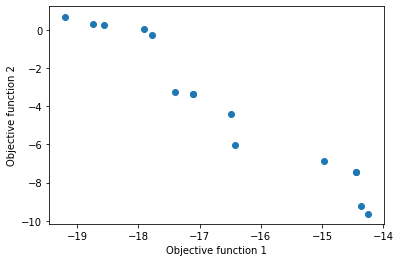

In [18]:
#__Output the results of the final population___________________________________________________________________________
# Pareto front visualization
fitness_values = evaluation(pop)
index = np.arange(pop.shape[0]).astype(int)
pareto_front_index = pareto_front_finding(fitness_values, index)
pop = pop[pareto_front_index, :]
print("_________________")
print("Optimal solutions:")
print("       x1               x2                 x3")
print(pop) # show optimal solutions
fitness_values = fitness_values[pareto_front_index]
print("______________")
print("Fitness values:")
print("  objective 1    objective 2")
print("      |              |")
print(fitness_values)
plt.scatter(fitness_values[:, 0],fitness_values[:, 1])
plt.xlabel('Objective function 1')
plt.ylabel('Objective function 2')
plt.show()

Solving the famous ZDT Benchmark, For example: ZDT3 
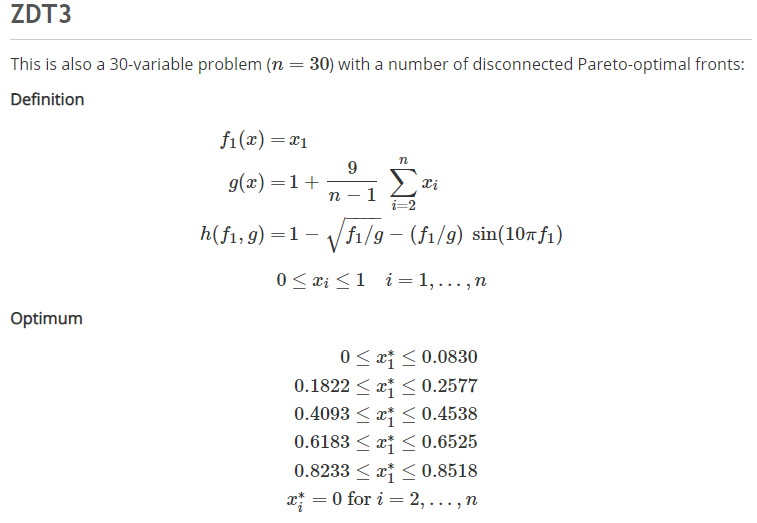

The true Pareto Front of ZDT3:
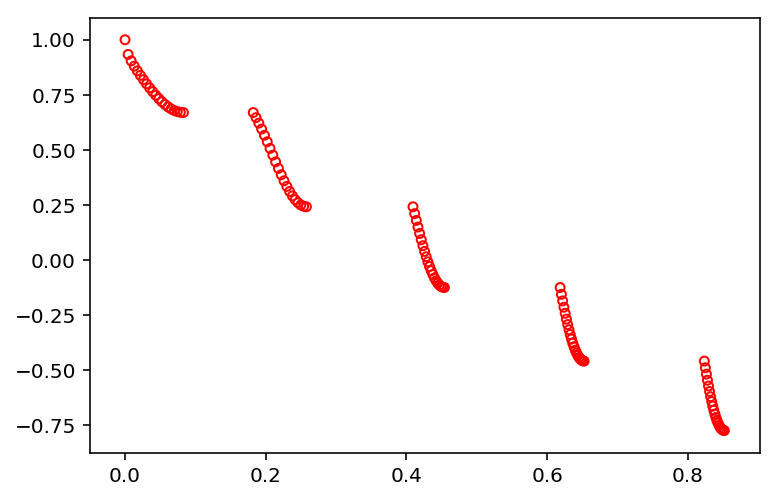

In [26]:
#_evaluate the fitness of the solutions (the objective values in the objective space)of ZDT3___________________________________________________________________________
def evaluation_zdt3(pop):
    fitness_values = np.zeros((pop.shape[0], 2)) # because of 2 objective functions
    for i, x in enumerate(pop):
        obj1 = x[1]
        obj2 = 0
        gx = 1
        for j in range(29):
            gx += (9.0/29)*(x[j+1])
        hx = 1 - (obj1/gx)*math.sin(10*math.pi*obj1) - math.sqrt(obj1/gx)
        obj2 = gx*hx
        fitness_values[i,0] = obj1 # objective 1
        fitness_values[i,1] = obj2 # objective 2
 
    return fitness_values

In [27]:
#_initialization___________________________________________________________________________
# Parameters
nv = 30
lb = list(range(nv))
ub = list(range(nv))
for i in range(nv):
    lb[i] = 0.0
    ub[i] = 1.0
pop_size = 100
rate_crossover = 20
rate_mutation = 20
rate_local_search = 10
step_size = 0.1
pop = random_population(nv,pop_size,lb,ub)

In [29]:
#_Using NSGAII to solve the ZDT3 Problem____________________________________________________________________________
# Main loop of NSGA II 
for i in range(100):
    offspring_from_crossover = crossover(pop,rate_crossover)
    offspring_from_mutation = mutation(pop,rate_mutation)
    offspring_from_local_search = local_search(pop, rate_local_search, step_size)
    # extend the population
    pop = np.append(pop, offspring_from_crossover, axis=0)
    pop = np.append(pop, offspring_from_mutation, axis=0)
    pop = np.append(pop, offspring_from_local_search, axis=0)
    fitness_values = evaluation_zdt3(pop)
    pop = selection(pop,fitness_values, pop_size)
    print('iteration:', i)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

_________________
Optimal solutions:
       x1               x2                 x3
[[0.24018123 0.         0.03764085 0.02445142 0.06326913 0.21283764
  0.19402841 0.16268902 0.13952807 0.09250262 0.32714216 0.00095048
  0.19914266 0.00877915 0.04086164 0.24819538 0.00886992 0.01076288
  0.12531767 0.01970457 0.11630144 0.24334147 0.0262844  0.21887378
  0.05107708 0.04230235 0.04590235 0.38149915 0.10577557 0.03808006]
 [0.16529855 0.04223058 0.03764085 0.00472072 0.04761332 0.21283764
  0.19402841 0.16268902 0.10273463 0.00824679 0.32714216 0.00095048
  0.19914266 0.00877915 0.04086164 0.19054115 0.00886992 0.01076288
  0.12531767 0.01970457 0.11630144 0.24334147 0.         0.21887378
  0.05107708 0.04230235 0.1145123  0.38149915 0.10577557 0.03783666]
 [0.1876811  0.64633201 0.03764085 0.02445142 0.09827988 0.21283764
  0.08627174 0.16268902 0.1750088  0.00309794 0.32752258 0.08061041
  0.19914266 0.         0.04086164 0.26328424 0.00886992 0.01076288
  0.12531767 0.01970457 0.11630

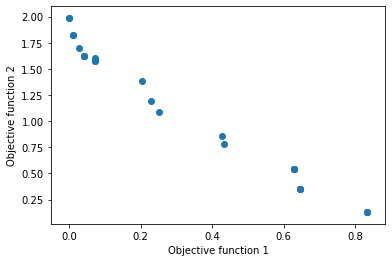

In [30]:
#__Output the results of the final population___________________________________________________________________________
# Pareto front visualization
fitness_values = evaluation_zdt3(pop)
index = np.arange(pop.shape[0]).astype(int)
pareto_front_index = pareto_front_finding(fitness_values, index)
pop = pop[pareto_front_index, :]
print("_________________")
print("Optimal solutions:")
print("       x1               x2                 x3")
print(pop) # show optimal solutions
fitness_values = fitness_values[pareto_front_index]
print("______________")
print("Fitness values:")
print("  objective 1    objective 2")
print("      |              |")
print(fitness_values)
plt.scatter(fitness_values[:, 0],fitness_values[:, 1])
plt.xlabel('Objective function 1')
plt.ylabel('Objective function 2')
plt.show()